In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import os
import artm
import numpy as np
from sklearn.datasets import dump_svmlight_file
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
output_file = "./output/data"
data_folder='./batches_new'
gexf_file='hcl_phi.gexf'
num_top_tokens = 20 # число топ слов
num_topics = 30 # число тем

Удаляем старые данные

In [2]:
import shutil
shutil.rmtree(data_folder)
os.mkdir(data_folder)

Далее вызываем count vectorizer, чтобы отфильтровать мусор, накладываем idf ограничения + меняем регулярку.

In [3]:
data_directory = '.'
emails = pd.read_csv(os.path.join(data_directory, 'Emails.csv'))
vectorizer = CountVectorizer(decode_error='replace', min_df=0.01, max_df=0.3, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z][a-zA-Z][a-zA-Z]+\b")
X = vectorizer.fit_transform(emails.RawText).todense()

table = vectorizer.get_feature_names()
fo = open("words.txt", "w")
print >>fo, table

print X.shape

(7945L, 1993L)


In [4]:
table = vectorizer.get_feature_names()
y = [i for i in xrange(X.shape[0])]
dump_svmlight_file( X, y, f = output_file, zero_based = True)

Создаем словарь и батчи

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path=output_file, data_format='vowpal_wabbit', target_folder=data_folder)

In [6]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=data_folder)

In [7]:
# os.remove('./batches/dictionary.dict')
# os.remove('./batches/dictionary_text')
dictionary.save(dictionary_path=data_folder + '/dictionary')
dictionary.save_text(dictionary_path=data_folder + 'dictionary_text')

Создаем модель

In [8]:
topic_names = ['topic_{}'.format(i) for i in xrange(num_topics)]
model_artm = artm.ARTM(topic_names=topic_names,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    use_unigram_document_model=False,
                                                    dictionary=dictionary)], cache_theta=True)
# не используем. ибо попытка выделить самые основные темы и еще фон не пошла.
part1 = topic_names[:len(topic_names / 2)]
part2 = topic_names[len(topic_names / 2):]

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=num_top_tokens))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15))

Далее в 2а этапа учим модель. В 2а проще, после 1го можжно было что-то поменять и улучшить.
Короче, я перелопапил кучу параметров в попытках получить какие-то осмысленные ядра. Но самая (на глаз) удачная модель получается с параметрами из туториала. Если же задаваться целью минимизировать перплексию, а не удачную на глаз модель, то порядок параметров должен быть ~0.5, кроме того я еще делал разбиение на 10 топ тем и еще 20 побочных в надежде, что 10 нужно "разрядить", а 20 сгладить (topic_names=...). Но это полный бред, или я не умею это готовить!!! Ничего не помогло.

Sparsity Phi: 0.639 (ARTM)
Sparsity Theta: 0.274 (ARTM)
Kernel contrast: 0.373 (ARTM)
Kernel purity: 0.848 (ARTM)
Perplexity: 709.900 (ARTM)


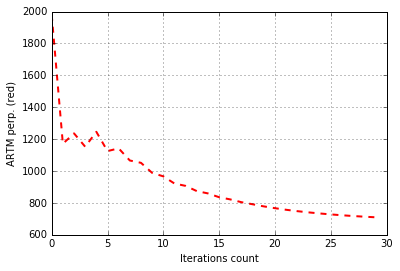

In [9]:
model_artm.num_document_passes = 1
model_artm.initialize(dictionary=dictionary)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

def print_measures(model_artm):
    print 'Sparsity Phi: {0:.3f} (ARTM)'.format(model_artm.score_tracker['SparsityPhiScore'].last_value)
    print 'Sparsity Theta: {0:.3f} (ARTM)'.format(model_artm.score_tracker['SparsityThetaScore'].last_value)
    print 'Kernel contrast: {0:.3f} (ARTM)'.format(model_artm.score_tracker['TopicKernelScore'].last_average_contrast)
    print 'Kernel purity: {0:.3f} (ARTM)'.format(model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print 'Perplexity: {0:.3f} (ARTM)'.format(model_artm.score_tracker['PerplexityScore'].last_value)

    plt.plot(xrange(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_artm)

Sparsity Phi: 0.822 (ARTM)
Sparsity Theta: 0.328 (ARTM)
Kernel contrast: 0.461 (ARTM)
Kernel purity: 0.936 (ARTM)
Perplexity: 682.705 (ARTM)


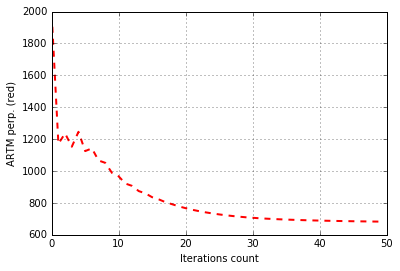

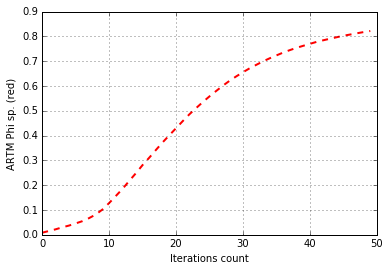

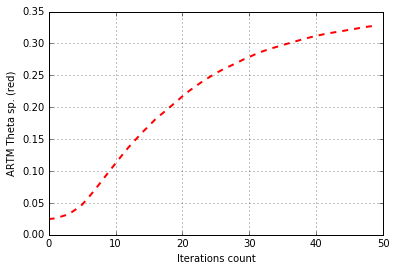

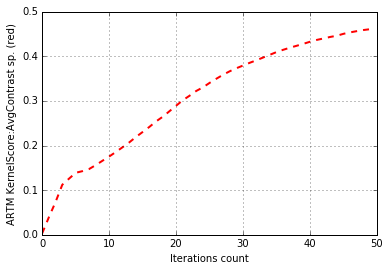

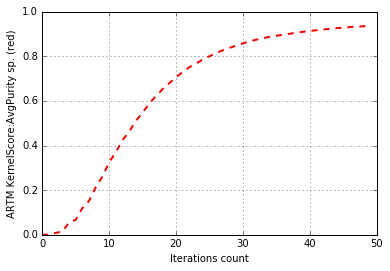

In [10]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.2))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=3.5e+5))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.2))
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

print_measures(model_artm)
plt.plot(xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp. (red)')
plt.grid(True)
plt.show()
plt.plot(xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (red)')
plt.grid(True)
plt.show()
plt.plot(xrange(model_artm.num_phi_updates), model_artm.score_tracker['TopicKernelScore'].average_contrast, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM KernelScore:AvgContrast sp. (red)')
plt.grid(True)
plt.show()
plt.plot(xrange(model_artm.num_phi_updates), model_artm.score_tracker['TopicKernelScore'].average_purity, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM KernelScore:AvgPurity sp. (red)')
plt.grid(True)
plt.show()

Выводим слова. Чтобы избежать проблем с кодировкой мы писали vowpal с id слов, теперь нужно сделать замену.

In [11]:
def idToWord(id):
    table = vectorizer.get_feature_names()
    return table[int(id)]

for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print [idToWord(token) for token in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]]

topic_0:  [u'american', u'group', u'under', u'being', u'only', u'general', u'members', u'ambassador', u'force', u'strong', u'important', u'european', u'leadership', u'europe', u'current', u'clear', u'cannot', u'threat', u'south', u'nato']
topic_1:  [u'very', u'last', u'much', u'many', u'help', u'where', u'women', u'hillary', u'working', u'best', u'great', u'because', u'family', u'question', u'doing', u'well', u'together', u'really', u'year', u'friends']
topic_2:  [u'there', u'what', u'your', u'like', u'week', u'going', u'want', u'come', u'lona', u'valmoro', u'next', u'valmorou', u'schedule', u'meet', u'dinner', u'coming', u'sure', u'night', u'tonight', u'special']
topic_3:  [u'time', u'good', u'speech', u'july', u'team', u'press', u'give', u'draft', u'send', u'questions', u'getting', u'later', u'better', u'idea', u'still', u'wrote', u'book', u'lissa', u'ready', u'minutes']
topic_4:  [u'united', u'states', u'political', u'such', u'years', u'nations', u'economic', u'between', u'term', u'

Примерные темы, часть конечно такие себе, но я решил, что лучше взять 30 и иметь лишние темы, чем 25 и что-то потерять.

In [27]:
real_topics_names = ["европа-нато",
"женщины",
"что-то про поход куда-то",
"про речи 1",
"политика в штатах",
"lauren??? а так кажется, что это какие-то секритарские штучки",
"бред какой-то. общие вещи 1",
"про выступления",
"бред какой-то. общие вещи 2",
"бред какой-то. общие вещи 3. что-то про Филлипины",
"про ирак",
"международная политика 1",
"здоровье клинтон/семья/дети",
"про обаму и правительство 2",
"обсуждение выборов",
"права людей",
"полика на востоке",
"бред какой-то. общие вещи 4",
"бред какой-то. общие вещи 5 (есть что-то про Россию, правда)",
"международная политика 2",
"про правительство и заседания",
"афганистан",
"куча имен. видимо какие-то переписки с людьми",
"политика и выборы",
"европа-германия",
"бред какой-то. общие вещи 6",
"про ливию",
"европа-англия",
"международная политика 3",
"ядерная программа ирана"]

Вывод матриц. Тут приведен код, который я использовал. Но обычно просто смотрел разные кусочки матрицы. Просто нужно отобразить ее в картинку

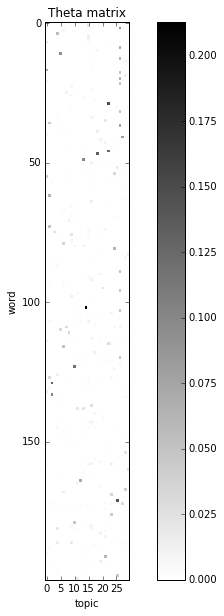

In [12]:
phi = model_artm.get_phi().values
def plot_matrix(matrix, figsize=(25,15), xlabel='', ylabel='', title='', save=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.binary)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
# можно смотреть по частям
plot_matrix(phi[:200, :], figsize=(10,10), xlabel='topic', ylabel='word', title='Theta matrix')
#print phi

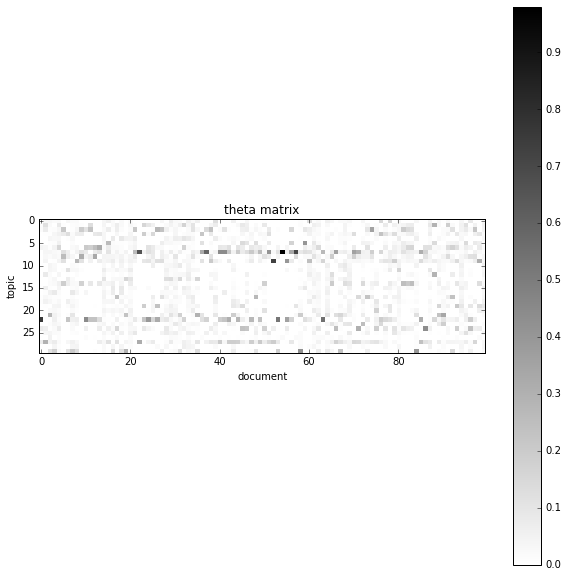

In [13]:
theta_matrix = model_artm.get_theta().values
plot_matrix(theta_matrix[:, 100:200], figsize=(10,10), xlabel='document', ylabel='topic',
            title='theta matrix')
#print theta_matrix

In [16]:
model = model_artm
unique, counter = {}, 1
for topic_index, topic_name in enumerate(model.topic_names):
    score_tracker = model.score_tracker['TopTokensScore']
    print topic_index
    var = score_tracker.last_tokens[topic_name]
    for i in xrange(len(var)):
        unique[idToWord(var[i])] = counter
        counter += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


 Если внимательно прочитать документацию, то узнаем, что переменные last_weights и им подобные выгружаются каждый раз
при вызове, что замедляет СИЛЬНО код. Лучше сначала выгрузить, потом обращаться.

In [28]:
with open(gexf_file, 'wb') as f:
    f.write('<gexf xmlns:viz="http:///www.gexf.net/1.1draft/viz" xmlns="http://www.gexf.net/1.1draft" version="1.1">\n')
    f.write('<meta lastmodifieddate="2010-03-03+23:44">\n')
    f.write('<creator>Gephi 0.7</creator>\n')
    f.write('</meta>\n')
    f.write('<graph defaultedgetype="undirected" idtype="string" type="static">\n')
    f.write('<nodes count="{}">\n'.format(len(unique) + num_topics))
    for token, value in unique.iteritems():
        f.write('<node id="{0}" label="{1}"/>\n'.format(value, token))
        for id in xrange(num_topics):
            f.write('<node id="{0}" label="TOPIC_{1}|{2}"/>\n'.format(counter + id, id, real_topics_names[id]))
    f.write('</nodes>\n')
    edge_id = 0
    strs_to_write = []
    p = 0
    topic_tokens = []
    topic_weights = []
    for topic_index, topic_name in enumerate(model.topic_names):
        var = score_tracker.last_tokens[topic_name]
        topic_tokens.append([idToWord(item) for item in var])
        topic_weights.append(score_tracker.last_weights[topic_name])
    print topic_tokens
    for token, value in unique.iteritems():
        p += 1
        print "Process %s, %d, %d of %d" % (token, value, p, counter)
        for topic_index, topic_name in enumerate(model.topic_names):
            score_tracker = model.score_tracker['TopTokensScore']
            for i in xrange(len(topic_weights[topic_index])):
                if topic_tokens[topic_index][i] == token:
                    strs_to_write.append('<edge id="{0}" source="{1}" target="{2}" weight="{3}"/>\n'.format(
                        edge_id, counter + topic_index, value, topic_weights[topic_index][i]))
                    edge_id += 1
    f.write('<edges count="{}">\n'.format(len(strs_to_write)))
    for elem in strs_to_write:
        f.write(elem)
    f.write('</edges>\n')
    f.write('</graph>\n')
    f.write('</gexf>\n')

[[u'american', u'group', u'under', u'being', u'only', u'general', u'members', u'ambassador', u'force', u'strong', u'important', u'european', u'leadership', u'europe', u'current', u'clear', u'cannot', u'threat', u'south', u'nato'], [u'very', u'last', u'much', u'many', u'help', u'where', u'women', u'hillary', u'working', u'best', u'great', u'because', u'family', u'question', u'doing', u'well', u'together', u'really', u'year', u'friends'], [u'there', u'what', u'your', u'like', u'week', u'going', u'want', u'come', u'lona', u'valmoro', u'next', u'valmorou', u'schedule', u'meet', u'dinner', u'coming', u'sure', u'night', u'tonight', u'special'], [u'time', u'good', u'speech', u'july', u'team', u'press', u'give', u'draft', u'send', u'questions', u'getting', u'later', u'better', u'idea', u'still', u'wrote', u'book', u'lissa', u'ready', u'minutes'], [u'united', u'states', u'political', u'such', u'years', u'nations', u'economic', u'between', u'term', u'relationship', u'both', u'region', u'interest